In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
import itertools
import time
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score

In [82]:
data = pd.read_csv('expanded', delimiter='\t', header=None, names=['characteristics'])
data = data['characteristics'].str.split(',', expand=True)
data = data.drop(range(7)).reset_index(drop=True)



In [83]:
# implement descriptive column names
column_names = ['edibility','cap_shape', 'cap_surface', 'cap_color', 'bruises', 
                'odor', 'gill_attachment', 'gill_spacing', 'gill_size', 'gill_color', 
                'stalk_shape', 'stalk_root', 'stalk_surface_above_ring', 'stalk_surface_below_ring', 
                'stalk_color_above_ring', 'stalk_color_below_ring', 'veil_type', 'veil_color', 
                'ring_number', 'ring_type', 'spore_print_color', 'population','habitat']
data.columns = column_names
data = data.drop(data[data.isnull().any(axis=1)].index)

In [84]:
# get dummy variables for two-level response
def var_transform (data):
    data['edibility']=data['edibility'].apply(lambda x: 1 if x=='EDIBLE' else 0)
    #data['odor']=data['odor'].apply(lambda x: 0 if x=='ALMOND' or x=='ANISE' else 1)
    # put further variable transformation here 
    return data
var_transform(data).head(2)

,edibility,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,1,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
1,1,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS


In [85]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load the dataset
df=data
# Convert categorical variables to dummy variables
df = pd.get_dummies(df, columns=['cap_shape', 'cap_surface', 'cap_color', 'bruises', 
                'odor', 'gill_attachment', 'gill_spacing', 'gill_size', 'gill_color', 
                'stalk_shape', 'stalk_root', 'stalk_surface_above_ring', 'stalk_surface_below_ring', 
                'stalk_color_above_ring', 'stalk_color_below_ring', 'veil_type', 'veil_color', 
                'ring_number', 'ring_type', 'spore_print_color', 'population','habitat'], drop_first=True)
# Calculate VIF for each predictor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
vif["Predictor"] = df.columns

# Print the VIF values
vif

/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,Predictor
0,inf,edibility
1,1.340183,cap_shape_CONICAL
2,8.278594,cap_shape_CONVEX
3,8.645659,cap_shape_FLAT
4,3.856771,cap_shape_KNOBBED
...,...,...
91,1.930608,habitat_MEADOWS
92,3.292256,habitat_PATHS
93,2.587564,habitat_URBAN
94,inf,habitat_WASTE


In [86]:
df.shape

(8416, 96)

In [87]:
vif_inf = vif[np.isinf(vif['VIF Factor'])]
vif_inf

,VIF Factor,Predictor
0,inf,edibility
18,inf,bruises_NO
20,inf,odor_CREOSOTE
21,inf,odor_FISHY
22,inf,odor_FOUL
23,inf,odor_MUSTY
24,inf,odor_NONE
25,inf,odor_PUNGENT
26,inf,odor_SPICY
29,inf,gill_size_NARROW


In [89]:
data = data.drop(['odor','veil_type', 'stalk_surface_below_ring', 'stalk_color_below_ring'], axis=1)

In [90]:
# create dummy variables for each categorical variable
cat_vars = list(data.select_dtypes(include=['object']).columns)
dummy_vars = pd.get_dummies(data[cat_vars], prefix=cat_vars)
# concatenate the dummy variables with the original dataset
data = pd.concat([data.drop(cat_vars, axis=1), dummy_vars], axis=1)

print(data.shape)

(8416, 95)


In [91]:
np.array(data.columns)

array(['edibility', 'cap_shape_BELL', 'cap_shape_CONICAL',
       'cap_shape_CONVEX', 'cap_shape_FLAT', 'cap_shape_KNOBBED',
       'cap_shape_SUNKEN', 'cap_surface_FIBROUS', 'cap_surface_GROOVES',
       'cap_surface_SCALY', 'cap_surface_SMOOTH', 'cap_color_BROWN',
       'cap_color_BUFF', 'cap_color_CINNAMON', 'cap_color_GRAY',
       'cap_color_GREEN', 'cap_color_PINK', 'cap_color_PURPLE',
       'cap_color_RED', 'cap_color_WHITE', 'cap_color_YELLOW',
       'bruises_BRUISES', 'bruises_NO', 'gill_attachment_ATTACHED',
       'gill_attachment_FREE', 'gill_spacing_CLOSE',
       'gill_spacing_CROWDED', 'gill_size_BROAD', 'gill_size_NARROW',
       'gill_color_BLACK', 'gill_color_BROWN', 'gill_color_BUFF',
       'gill_color_CHOCOLATE', 'gill_color_GRAY', 'gill_color_GREEN',
       'gill_color_ORANGE', 'gill_color_PINK', 'gill_color_PURPLE',
       'gill_color_RED', 'gill_color_WHITE', 'gill_color_YELLOW',
       'stalk_shape_ENLARGING', 'stalk_shape_TAPERING', 'stalk_root_?',
       '

# Feature Selection for model without Odor

In [94]:
import itertools
import time
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('ggplot')

In [95]:
data

,edibility,cap_shape_BELL,cap_shape_CONICAL,cap_shape_CONVEX,cap_shape_FLAT,cap_shape_KNOBBED,cap_shape_SUNKEN,cap_surface_FIBROUS,cap_surface_GROOVES,cap_surface_SCALY,...,population_SCATTERED,population_SEVERAL,population_SOLITARY,habitat_GRASSES,habitat_LEAVES,habitat_MEADOWS,habitat_PATHS,habitat_URBAN,habitat_WASTE,habitat_WOODS
0,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8411,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8412,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
8413,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8414,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


In [96]:
from sklearn.model_selection import train_test_split
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['edibility'], axis=1),
    data['edibility'],
    test_size=0.15,
    random_state=23)

X_train.shape, X_test.shape

((7153, 94), (1263, 94))

In [97]:
cutoff=0.5
def fit_linear_reg(X,Y):
    # Fit linear regression model and return classification accuracy
    model_k = linear_model.LinearRegression()
    model_k.fit(X, Y)

    # Predicted vs Actual
    actual_values = Y
    pred_values = model_k.predict(X)
    bins = np.array([0, cutoff, 1])
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]

    # Calculate the accuracy
    accuracy = (cm[0,0] + cm[1,1]) / cm.sum()
    fpr = (cm[0,1]) / (cm[0,0] + cm[0,1])

    #print("Classification accuracy = {:.1%}".format(accuracy))
    #print("FPR = {:.1%}".format(fpr))

    return accuracy, fpr

In [100]:
#forward selection
k = 94

remaining_features = list(X_train.columns.values)
features = []
accuracy_list, fpr_list = [np.inf], [np.inf] #Due to 1 indexing of the loop...
features_list = dict()

for i in range(1,k+1):
    best_accuracy = np.inf
    
    for combo in itertools.combinations(remaining_features,1):

            accuracy = fit_linear_reg(X_train[list(combo) + features],y_train)   #Store temp result 

            if accuracy[0] < best_accuracy:
                best_accuracy = accuracy[0]
                best_fpr = accuracy[1] 
                best_feature = combo[0]

    #Updating variables for next loop
    features.append(best_feature)
    remaining_features.remove(best_feature)
    
    #Saving values for plotting
    accuracy_list.append(best_accuracy)
    fpr_list.append(best_fpr)
    features_list[i] = features.copy()

In [101]:
df = pd.concat([pd.DataFrame({'features':features_list}),pd.DataFrame({'accuracy':accuracy_list, 'fpr': fpr_list})], axis=1, join='inner')
df['numb_features'] = df.index
df.tail(10)

,features,accuracy,fpr,numb_features
85,"[population_ABUNDANT, spore_print_color_BUFF, ...",0.948898,0.080420,85
86,"[population_ABUNDANT, spore_print_color_BUFF, ...",0.968537,0.031008,86
87,"[population_ABUNDANT, spore_print_color_BUFF, ...",0.967969,0.023023,87
88,"[population_ABUNDANT, spore_print_color_BUFF, ...",0.965736,0.028362,88
89,"[population_ABUNDANT, spore_print_color_BUFF, ...",0.965603,0.029084,89
90,"[population_ABUNDANT, spore_print_color_BUFF, ...",0.965263,0.028404,90
91,"[population_ABUNDANT, spore_print_color_BUFF, ...",0.973940,0.000532,91
92,"[population_ABUNDANT, spore_print_color_BUFF, ...",0.974000,0.000537,92
93,"[population_ABUNDANT, spore_print_color_BUFF, ...",1.000000,0.000000,93
94,"[population_ABUNDANT, spore_print_color_BUFF, ...",1.000000,0.000000,94


In [15]:
df.features.iloc[-1]

['stalk_color_above_ring_GRAY',
 'stalk_color_below_ring_YELLOW',
 'veil_type_PARTIAL',
 'cap_color_PURPLE',
 'ring_type_FLARING',
 'cap_color_PINK',
 'cap_shape_SUNKEN',
 'spore_print_color_ORANGE',
 'odor_CREOSOTE',
 'spore_print_color_YELLOW',
 'stalk_color_above_ring_RED',
 'cap_color_BUFF',
 'gill_color_YELLOW',
 'spore_print_color_PURPLE',
 'veil_color_WHITE',
 'gill_color_ORANGE',
 'veil_color_BROWN',
 'spore_print_color_GREEN',
 'stalk_color_below_ring_RED',
 'habitat_WASTE',
 'habitat_URBAN',
 'gill_color_RED',
 'cap_surface_SMOOTH',
 'cap_color_BROWN',
 'spore_print_color_BUFF',
 'cap_shape_CONICAL',
 'cap_surface_GROOVES',
 'odor_MUSTY',
 'stalk_color_above_ring_ORANGE',
 'stalk_color_above_ring_YELLOW',
 'gill_attachment_ATTACHED',
 'stalk_color_below_ring_ORANGE',
 'gill_attachment_FREE',
 'cap_color_GREEN',
 'veil_color_ORANGE',
 'veil_color_YELLOW',
 'population_CLUSTERED',
 'cap_shape_FLAT',
 'population_SOLITARY',
 'stalk_color_above_ring_CINNAMON',
 'odor_PUNGENT',
 '

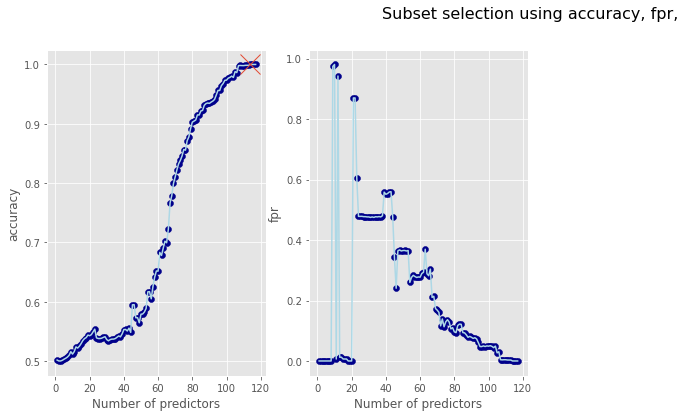

In [16]:
variables = ['accuracy','fpr']
fig = plt.figure(figsize = (18,6))

for i,v in enumerate(variables):
    ax = fig.add_subplot(1, 4, i+1)
    ax.plot(df['numb_features'],df[v], color = 'lightblue')
    ax.scatter(df['numb_features'],df[v], color = 'darkblue')
    if v == 'accuracy':
        ax.plot(df[v].idxmax(),df[v].max(), marker = 'x', markersize = 20)
    else:
        ax.plot(df[v].idxmin(),df[v].min(), markersize = 20)
    ax.set_xlabel('Number of predictors')
    ax.set_ylabel(v)

fig.suptitle('Subset selection using accuracy, fpr, ', fontsize = 16)
plt.show()

In [17]:
##also forward selection, but using Machine learning

In [18]:
!pip install mlxtend

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs_forward = SFS(LogisticRegression(), 
                  k_features=20, 
                  forward=True, 
                  floating=False, 
                  verbose=2,
                  scoring='accuracy',
                  cv=5)
sfs_forward = sfs_forward.fit(np.array(X_train), y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  94 out of  94 | elapsed:    2.4s finished

[2023-03-10 00:38:46] Features: 1/20 -- score: 0.7778584099338816[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:    3.0s finished

[2023-03-10 00:38:49] Features: 2/20 -- score: 0.9036792697170055[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  92 out of  92 | elapsed:    3.3s finished

[2023-03-10 00:38:53] Features: 3/20 -- score: 0.9499521582540449[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [52]:
selected_features = X_train.columns[list(sfs_forward.k_feature_idx_)]
selected_features

Index(['cap_shape_BELL', 'cap_shape_CONICAL', 'cap_shape_KNOBBED',
       'cap_shape_SUNKEN', 'cap_surface_GROOVES', 'cap_surface_SCALY',
       'cap_color_BROWN', 'cap_color_CINNAMON', 'cap_color_GRAY',
       'cap_color_PINK', 'gill_spacing_CLOSE', 'gill_size_BROAD',
       'gill_color_BUFF', 'stalk_surface_above_ring_SILKY',
       'ring_type_FLARING', 'spore_print_color_CHOCOLATE',
       'spore_print_color_GREEN', 'population_CLUSTERED',
       'population_SCATTERED', 'population_SOLITARY'],
      dtype='object')

In [53]:
# Evaluate the model using the selected feature subset
logreg = LogisticRegression()
logreg.fit(X_train[selected_features], y_train)
y_pred = logreg.predict(X_test[selected_features])
accuracy = accuracy_score(y_test, y_pred)

In [54]:
# Calculate FPR using ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
fpr = fpr[1]  # FPR at TPR=0.5 (i.e., when the threshold is set to maximize balanced accuracy)
print('Accuracy:', accuracy)
print('False positive rate:', fpr)

Accuracy: 0.9920823436262867
False positive rate: 0.00686106346483705


In [55]:
#Calculate recall
from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred)
print('Recall:', recall)

Recall: 0.9911764705882353


In [59]:
#backward selection
sfs_backward = SFS(LogisticRegression(), 
                   k_features=20, 
                   forward=False, 
                   floating=False, 
                   verbose=2,
                   scoring='accuracy',
                   cv=5)
sfs_backward = sfs_backward.fit(np.array(X_train), y_train)

/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

In [32]:
# Get the selected feature subset
selected_features_bwd = X_train.columns[list(sfs_backward.k_feature_idx_)]
selected_features_bwd

Index(['cap_shape_BELL', 'cap_shape_CONICAL', 'cap_shape_CONVEX',
       'cap_shape_FLAT', 'cap_shape_KNOBBED', 'cap_shape_SUNKEN',
       'cap_surface_FIBROUS', 'cap_surface_GROOVES', 'cap_surface_SCALY',
       'bruises_BRUISES', 'odor_ALMOND', 'odor_ANISE', 'odor_CREOSOTE',
       'odor_FISHY', 'odor_FOUL', 'odor_SPICY', 'gill_size_BROAD',
       'stalk_root_CLUB', 'stalk_surface_above_ring_SILKY',
       'spore_print_color_GREEN'],
      dtype='object')

In [33]:
# Evaluate the model using the selected feature subset
logreg = LogisticRegression()
logreg.fit(X_train[selected_features_bwd], y_train)
y_pred = logreg.predict(X_test[selected_features_bwd])
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

In [34]:
# Calculate FPR using ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
fpr = fpr[1]  # FPR at TPR=0.5 (i.e., when the threshold is set to maximize balanced accuracy)
print('Accuracy:', accuracy)
print('False positive rate:', fpr)
print('Recall:', recall)

Accuracy: 1.0
False positive rate: 0.0
Recall: 1.0


In [78]:
consistent_features = ['cap_shape_BELL', 'cap_shape_CONICAL', 'cap_shape_CONVEX', 'cap_shape_FLAT', 'cap_shape_KNOBBED', 'cap_shape_SUNKEN', 'cap_surface_GROOVES', 'cap_surface_SCALY', 'bruises_BRUISES', 'stalk_root_CLUB', 'stalk_surface_above_ring_SILKY', 'spore_print_color_GREEN']
consistent_features

['cap_shape_BELL',
 'cap_shape_CONICAL',
 'cap_shape_CONVEX',
 'cap_shape_FLAT',
 'cap_shape_KNOBBED',
 'cap_shape_SUNKEN',
 'cap_surface_GROOVES',
 'cap_surface_SCALY',
 'bruises_BRUISES',
 'stalk_root_CLUB',
 'stalk_surface_above_ring_SILKY',
 'spore_print_color_GREEN']

Using k=20, forward and backward selection processes resulted in the consistent selection of the following features: cap_shape_BELL, cap_shape_CONICAL, cap_shape_CONVEX, cap_shape_FLAT, cap_shape_KNOBBED, cap_shape_SUNKEN, cap_surface_GROOVES, cap_surface_SCALY, bruises_BRUISES, stalk_root_CLUB, stalk_surface_above_ring_SILKY, and spore_print_color_GREEN.

In [79]:
# Evaluate the model using the consistently selected feature subset
logreg = LogisticRegression()
logreg.fit(X_train[consistent_features], y_train)
y_pred = logreg.predict(X_test[consistent_features])
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

In [80]:
# Calculate FPR using ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
fpr = fpr[1]  # FPR at TPR=0.5 (i.e., when the threshold is set to maximize balanced accuracy)
print('Accuracy:', accuracy)
print('False positive rate:', fpr)
print('Recall:', recall)

Accuracy: 0.8479809976247031
False positive rate: 0.27615780445969124
Recall: 0.9544117647058824
